(einops_tutorial)=
# Einops tutorial (ported)

This tutorial is a port using `xarray-einstats` of the [einops basics tutorial](https://einops.rocks/1-einops-basics)

## Einops meets xarray!

We don't write 
```python
y = x.transpose(0, 2, 3, 1)
```
nor we write the more comprehensible alternative
```python
y = rearrange(x, 'b c h w -> b h w c')
```
we write comprehensible code and use labeled arrays

```python
y_da = rearrange(x_da, 'batch height width channel')
# or, also equivalent
y_da = x_da.einops.rearrange('batch height width channel')
```
`x_da` is a {class}`xarray.DataArray` whose dimensions are already labeled, thus,
we can skip the left side that defines the names of the dimensions.

`xarray-einstats` wraps [`einops`](https://einops.rocks/) functions to extend them to work on xarray objects.

## What's in this tutorial?

- fundamentals: reordering, composition and decomposition of axes
- operations: `rearrange`, `reduce`, `repeat`
- how much you can do with a single operation!

## Preparations

In [1]:
# Examples are given for numpy. This code also setups ipython/jupyter
# so that numpy arrays in the output are displayed as images
import numpy
import xarray
from xarray_einstats.tutorial import display_np_arrays_as_images

display_np_arrays_as_images()

:::{note}
This cell above configures jupyter to display _numpy_ arrays as images, which is a great visual help to understand
the operations performed by einops. To take advantage of this we use `.values`. In some specific cases, we also omit it in order to show the values of the dimensions of the DataArray. If you are running this yourself we encourage you to try both views
:::

## Load a batch of images to play with

:::{admonition} Download the data for local use
:class: dropdown

The images are stored as a [zarr store](https://zarr.dev/) in the xarray-einstats repo. You can download it directly from your browser using https://download-directory.github.io/ and
pasting [https://github.com/arviz-devs/xarray-einstats/tree/main/docs/source/tutorials/einops-image.zarr](https://github.com/arviz-devs/xarray-einstats/tree/main/docs/source/tutorials/einops-image.zarr) there. Then move the file if necessary, uncompress and rename it so you can load it with {func}`~xarray.open_zarr` as shown below.
:::

In [2]:
ds = xarray.open_zarr("einops-image.zarr").load()
ims = ds["ims"]
# There are 6 images of shape 96x96 with 3 color channels packed into the ims DataArray
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (batch: 6, height: 96, width: 96, channel: 3)
Dimensions without coordinates: batch, height, width, channel
Data variables:
    ims      (batch, height, width, channel) float64 1MB 1.0 0.902 ... 0.8039

display the first image (whole 4d tensor can't be rendered)

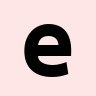

In [3]:
ims.sel(batch=0).values

second image in a batch

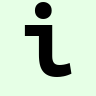

In [4]:
ims.sel(batch=1).values

we'll use three operations

In [5]:
from xarray_einstats.einops import rearrange, reduce #, repeat

{func}`~xarray_einstats.einops.rearrange`, as its name suggests, rearranges elements.

Below we swapped height and width.
This can be seen as transposing the first two dimensions, but _in xarray_, by design, the order of the dimensions
should not matter, and that exact code below should (and will work) if the input object
has the same dimension names but different order (in which case the operation might be transposing 1st and 3rd dims)
_or doing nothing_. Having said that, rearranging is still a valuable operation on xarray objects, especially
if done right before accessing the underlying numpy or dask array.

By rearranging, we are enforcing the width, height, channel order.

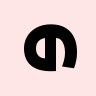

In [6]:
ims.sel(batch=0).einops.rearrange('width height channel').values

## Composition of axes
transposition is very common and useful, but let's move to other capabilities provided by einops

einops allows seamlessly composing batch and height to a new height dimension, something that tends
to be tricky in xarray once we move from a standard {meth}`~xarray.Dataset.stack`.

We just rendered all images by collapsing to 3d tensor!

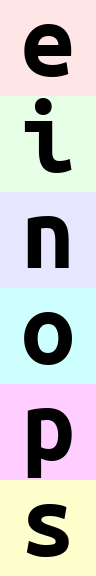

In [7]:
da = rearrange(ims, '(batch height) width channel')
da.values

but wait, dimensions must be named in xarray, so what happened with this stacked dimension we have just created?

`xarray_einstats` assigns it a dimension name based on the names of the parent dimensions:

In [8]:
da.dims

('batch-height', 'width', 'channel')

we can also compose a new dimension of batch and width. And now we will name it manually (strongly recommended over relying on the automatic names)

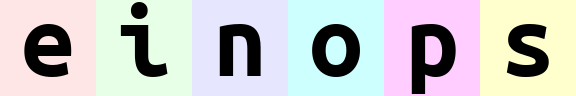

In [9]:
ims.einops.rearrange('(batch width)=batched_widths channel').values

note that here we have skipped the `height` dimension not only from the input but also from the
output expression. `xarray_einstats` follows xarray convention of adding the new or modified (aka 
present in the output expression) dimensions at the end. 

As dimensions are already named, we can skip dimensions not only from the input as we have been doing
but also from the output if we don't mind the new dimensions being moved to the right of the omitted ones.

Resulting dimensions are computed very simply. The length of newly composed axis is a product of components:
`[6, 96, 96, 3] -> [96, (6 * 96), 3]`

In [10]:
rearrange(ims, '(batch width) channel').shape

(96, 576, 3)

We can compose more than two axes. Let's flatten 4d array into 1d, resulting array has as many elements as the original

In [11]:
rearrange(ims, '(batch height width channel)').shape

(165888,)

:::{note}
Everything we have done so far could have been done with {meth}`~xarray.Dataset.transpose` or with
{meth}`~xarray.Dataset.stack`, so choosing between those methods or einops is a matter of personal 
choice. We'd recommend you stick with the original xarray methods, especially if working
with dask arrays, their defaults will be much more convenient than the lack of automatic dask handling
in `xarray_einstats`. 

The rearrangements below this point however can't be reproduced by a single xarray method.
:::

## Decomposition of axis
Decomposition is the inverse process, we represent an axis as a combination of new axes.

There will always be several decompositions possible, so we specify `b1=2`
to decompose `batch` to two dimensions `b1` and `b2` of lengths 2 and 3 respectively.

In addition, we also need to specify the name of the dimension we want to decompose.

In [12]:
ims.einops.rearrange('(b1 b2)=batch -> b1 b2 height width channel ', b1=2).shape

(2, 3, 96, 96, 3)

Finally, combine composition and decomposition:

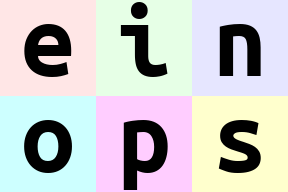

In [13]:
da = rearrange(ims, '(b1 b2)=batch -> (b1 height) (b2 width) channel ', b1=2)
da.values

Again, we skip naming the output dimensions so they are named by `xarray_einstats`

In [14]:
da.dims

('b1-height', 'b2-width', 'channel')

Slightly different composition: b1 is merged with width, b2 with height

... so letters are ordered by w then by h

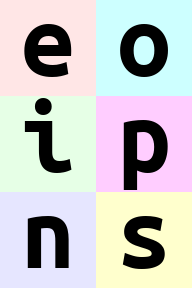

In [15]:
rearrange(ims, '(b1 b2)=batch -> (b2 height) (b1 width) channel ', b1=2).values

Wove part of width dimension to height. We should call this width-to-height as image width shrunk by 2 and height doubled. 

**but all pixels are the same!**

> Can you write reverse operation (height-to-width)?

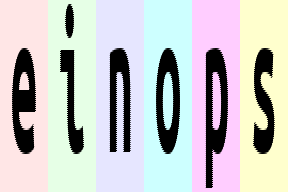

In [16]:
rearrange(ims, '(w1 w2)=width -> (height w2) (batch w1) channel', w2=2).values

## Order of axes matters
Compare with the next two examples


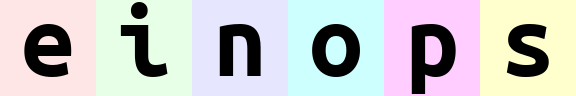

In [17]:
rearrange(ims, '(batch width) channel').values

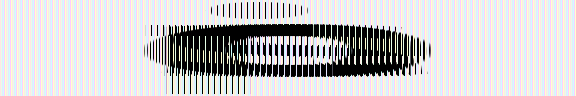

In [18]:
rearrange(ims, '(width batch) channel').values

The order of axes in the composition is different. 

The rule is just as for digits in the number: the leftmost digit is the most significant, while neighboring numbers differ in the rightmost axis. You can also think of this as lexicographic sort

And what if b1 and b2 are reordered before composing to width?

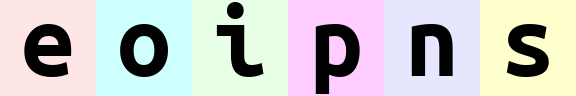

In [19]:
rearrange(ims, '(b1 b2)=batch -> (b1 b2 width) channel ', b1=2).values # produces 'einops'
rearrange(ims, '(b1 b2)=batch -> (b2 b1 width) channel ', b1=2).values # produces 'eoipns'

## Meet `reduce`

From einops documentation:

> In einops-land you don't need to guess what happened
> ```python
> x.mean(-1)
> ```
> Because you write what the operation does
> ```python
> reduce(x, 'b h w c -> b h w', 'mean')
> ```
>
> if an axis is not present in the output — you guessed it — that axis is reduced.

using xarray objects, you already don't have to guess what happened. Much like with `rearrange`,
the first examples (three in this case) using reduce can be reproduced with a single xarray method. See the
operation above with pure xarray and with `reduce`:

```
da.mean("channel")
reduce(x, "batch width height", "mean")
```

However, again much like with `rearrange`, `reduce` also opens the door to many other operations
that go beyond what single xarray methods can do. These cases are worth making `reduce` work, 
and once it's working the simple operations are possible automatically.

If you prefer thinking in terms of the dimensions that are kept instead of the ones that are reduced, 
using `reduce` can be more convenient even for simple operations.

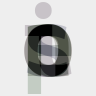

In [20]:
# average over batch
ims.einops.reduce('height width channel', 'mean').values

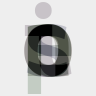

In [21]:
# the previous is identical to:
ims.mean(dim="batch")    # as xarray operation
ims.values.mean(axis=0)  # as numpy operation

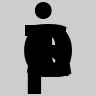

In [22]:
# Example of reducing of several axes 
# besides mean, there are also min, max, sum, prod
reduce(ims, 'height width', 'min').values

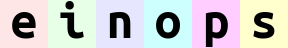

In [23]:
# this is mean-pooling with 2x2 kernel
# image is split into 2x2 patches, each patch is averaged
reduce(ims, '(h h2)=height (w w2)=width -> h (batch w) channel', 'mean', h2=2, w2=2).values

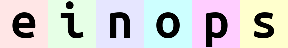

In [24]:
# max-pooling is similar
# result is not as smooth as for mean-pooling
ims.einops.reduce('(h h2)=height (w w2)=width -> h (batch w) channel', 'max', h2=2, w2=2).values

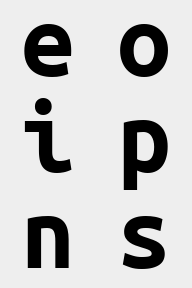

In [25]:
# yet another example. Can you compute result shape?
reduce(ims, '(b1 b2)=batch -> (b2 height) (b1 width)', 'mean', b1=2).values

We skip the section about numpy-like stacking and concatenating because they aren't relevant to xarray objects.

We have also reimagined the next section. We are working with xarray objects so adding
new axis of length 1 to ensure broadcastability is not relevant either. We have therefore
modified the section to a showcase of xarray automatic broadcasting and alignment.

## Broadcasting and alignment

As we are using xarray objects, we can directly operate between original and reduced inputs without 
the need for adding new dimensions, be it with `[np.newaxis, :]` or with `1` and `()` placeholders
in einops expressions. See for yourself:

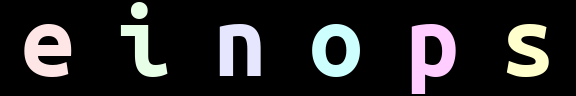

In [26]:
# compute max in each image individually, then show a difference 
x = reduce(ims, 'batch channel', 'max') - ims
rearrange(x, '(batch width) channel').values

## Repeating elements

**coming soon**, for now jump to {ref}`einops_examples`

Third operation we introduce is `repeat`

In [ ]:
# repeat along a new axis. New axis can be placed anywhere
repeat(ims[0], 'h w c -> h new_axis w c', new_axis=5).shape

In [ ]:
# shortcut
repeat(ims[0], 'h w c -> h 5 w c').shape

In [ ]:
# repeat along w (existing axis)
repeat(ims[0], 'h w c -> h (repeat w) c', repeat=3)

In [ ]:
# repeat along two existing axes
repeat(ims[0], 'h w c -> (2 h) (2 w) c')

In [ ]:
# order of axes matters as usual - you can repeat each element (pixel) 3 times 
# by changing order in parenthesis
repeat(ims[0], 'h w c -> h (w repeat) c', repeat=3)

Note: `repeat` operation covers functionality identical to `numpy.repeat`, `numpy.tile` and actually more than that.

## Reduce ⇆ repeat

reduce and repeat are like opposite of each other: first one reduces amount of elements, second one increases.

In the following example each image is repeated first, then we reduce over new axis to get back original tensor. Notice that operation patterns are "reverse" of each other

In [ ]:
repeated = repeat(ims, 'b h w c -> b h new_axis w c', new_axis=2)
reduced = reduce(repeated, 'b h new_axis w c -> b h w c', 'min')
assert numpy.array_equal(ims, reduced)

(einops_examples)=
## Fancy examples in random order

(a.k.a. mad designer gallery)

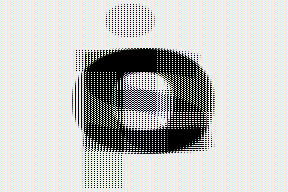

In [27]:
# interweaving pixels of different pictures
# all letters are observable
rearrange(ims, '(b1 b2)=batch -> (height b1) (width b2) channel ', b1=2).values

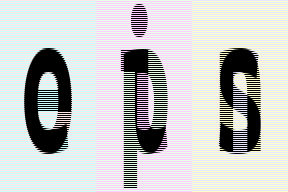

In [28]:
# interweaving along vertical for couples of images
ims.einops.rearrange('(b1 b2)=batch -> (height b1) (b2 width) channel', b1=2).values

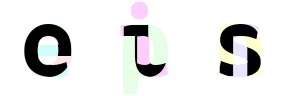

In [29]:
# interweaving lines for couples of images
# exercise: achieve the same result without einops in your favourite framework
reduce(ims, '(b1 b2)=batch -> height (b2 width) channel', 'max', b1=2).values

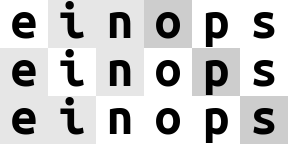

In [30]:
# color can be also composed into dimension
# ... while image is downsampled
reduce(ims, '(h h2)=height (w w2)=width -> (channel h) (batch w)', 'mean', h2=2, w2=2).values

In [31]:
# disproportionate resize
reduce(ims, '(h h4)=height (w w3)=width -> h (batch w)', 'mean', h4=4, w3=3).values

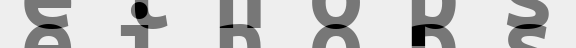

In [32]:
# spilt each image in two halves, compute mean of the two
ims.einops.reduce('(h1 h2)=height -> h2 (batch width)', 'mean', h1=2).values

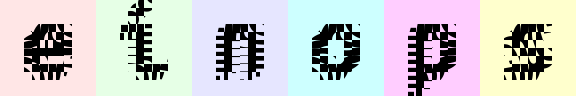

In [33]:
# split in small patches and transpose each patch
rearrange(ims, '(h1 h2)=height (w1 w2)=width -> (h1 w2) (batch w1 h2) channel', h2=8, w2=8).values

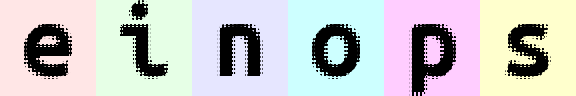

In [34]:
# stop me someone!
rearrange(
    ims, 
    '(h1 h2 h3)=height (w1 w2 w3)=width -> (h1 w2 h3) (batch w1 h2 w3) channel', 
    h2=2, w2=2, w3=2, h3=2
).values

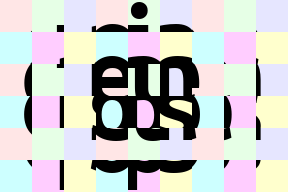

In [35]:
rearrange(
    ims, 
    '(b1 b2)=batch (h1 h2)=height (w1 w2)=width -> (h1 b1 h2) (w1 b2 w2) channel', 
    h1=3, w1=3, b2=3
).values

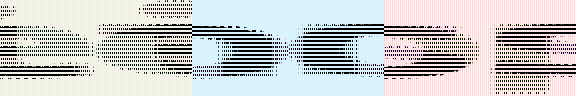

In [36]:
# patterns can be arbitrarily complicated
ims.einops.reduce(
    '(b1 b2)=batch (h1 h2 h3)=height (w1 w2 w3)=width -> (h1 w1 h3) (b1 w2 h2 w3 b2) channel', 
    'mean', h2=2, w1=2, w3=2, h3=2, b2=2
).values

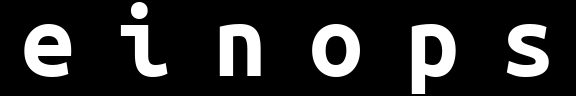

In [37]:
# subtract background in each image individually and normalize
im2 = reduce(ims, 'batch channel', 'max') - ims
im2 /= reduce(im2, 'batch channel', 'max')
rearrange(im2, '(batch width) channel').values

In [ ]:
##### no repeat yet ####
# pixelate: first downscale by averaging, then upscale back using the same pattern
averaged = reduce(ims, 'b (h h2) (w w2) c -> b h w c', 'mean', h2=6, w2=8)
repeat(averaged, 'b h w c -> (h h2) (b w w2) c', h2=6, w2=8)

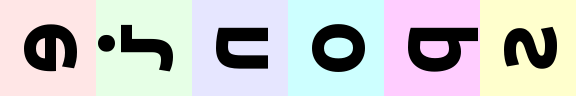

In [38]:
rearrange(ims, '(batch height) channel').values

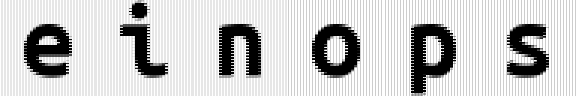

In [39]:
# let's bring color dimension as part of horizontal axis
# at the same time horizontal axis is downsampled by 2x
reduce(ims, '(h h2)=height (w w2)=width -> (h w2) (batch w channel)', 'mean', h2=3, w2=3).values

## Summary

- `rearrange` doesn't change number of elements and covers different numpy functions (like `transpose`, `reshape`, `stack`, `concatenate`,  `squeeze` and `expand_dims`)
- `reduce` combines same reordering syntax with reductions (`mean`, `min`, `max`, `sum`, `prod`, and any others)
- `repeat` additionally covers repeating and tiling
- composition and decomposition of axes are a corner stone, they can and should be used together

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p einops,xarray_einstats

Last updated: Thu, 19 Feb 2026

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

einops         : 0.8.2
xarray_einstats: 0.10.0

numpy          : 2.3.5
xarray         : 2025.11.0
xarray_einstats: 0.10.0

Watermark: 2.6.0

